In [1]:
import os
import sys
import scipy.sparse as sparse
import numpy as np
import pickle
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pylab as plt

%matplotlib inline

In [2]:
input_file = "feature-sef-df.pkl"

## The Input Data
First let's look at the data. The input data frame is containers (rows) by features (columns). The feature names are prefixed by the package name, either "Apt" or "Pip." If we do clustering without filtering features to either of these sets, we are logically going to see clustering based on that alone. it's typical that containers with some Python application (and a subset of Apt maybe) are going to look different than containers with no Python. 

In [3]:
results = pickle.load(open(input_file,'rb'))

In [4]:
results.head()

,Apt__liblockfile-dev,Pip__pytrends,Apt__libipmidetect0,Apt__qtenginio5-doc,Apt__ros-indigo-eigen-conversions,Apt__marble-data,Apt__libapache2-mod-php5.6,Apt__dde-desktop,Apt__libopus-dev,Apt__libscope-guard-perl,...,Apt__appmenu-qt5,Apt__zimbra-lmdb,Apt__thunar-data,Apt__cuda-nvgraph-dev-9-2,Apt__libomp5-7,Apt__libcloog-pplv4-1,Apt__libevent-core-2.0-5,Apt__zimbra-perl-io-compress,Apt__llvm-8-runtime,Apt__libjpeg8-dev
kurioapps/apib-tool,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
kblr/ubuntu18.04-ansible,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
citizenlabdotco/cl-devops-docs-portal-buildenv,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
jesusmatosp/docker-web,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
jaysong/sails,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


The above matrix head, in seeing lots of 0s, suggests that the matrix is very sparse! How sparse is it? We can calculate a percentage of data that is 0s (a percent sparse)

In [5]:
## Percent sparse
sum(sum(results.values)) / (results.shape[0] * results.shape[1])

0.004922280211511118

In [6]:
## lil_matix is fast to build
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html
M = sparse.lil_matrix(np.array(results.values, dtype=int))

In [7]:
# Compressed Sparse Row Matrix
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html
M = sparse.csr_matrix(M)  ## csr matrix is fast to work with

In [8]:
M

<6278x32913 sparse matrix of type '<class 'numpy.int64'>'
	with 1017080 stored elements in Compressed Sparse Row format>

In [9]:
def sparse_size(a):
    return  a.data.nbytes + a.indptr.nbytes + a.indices.nbytes

In [10]:
sparse_size(M)/1e6 ## size in MB

12.230076

## Preliminary analysis: truncated SVD to 2 dimensions
Truncated SVD (singular value decomposition) means we don't center the data first. So it works well for sparse data

In [11]:
tsvd = TruncatedSVD()
T = tsvd.fit_transform(M)
print(tsvd.explained_variance_ratio_)
print(tsvd.explained_variance_ratio_.sum())

[0.37019163 0.10112333]
0.47131495882435376


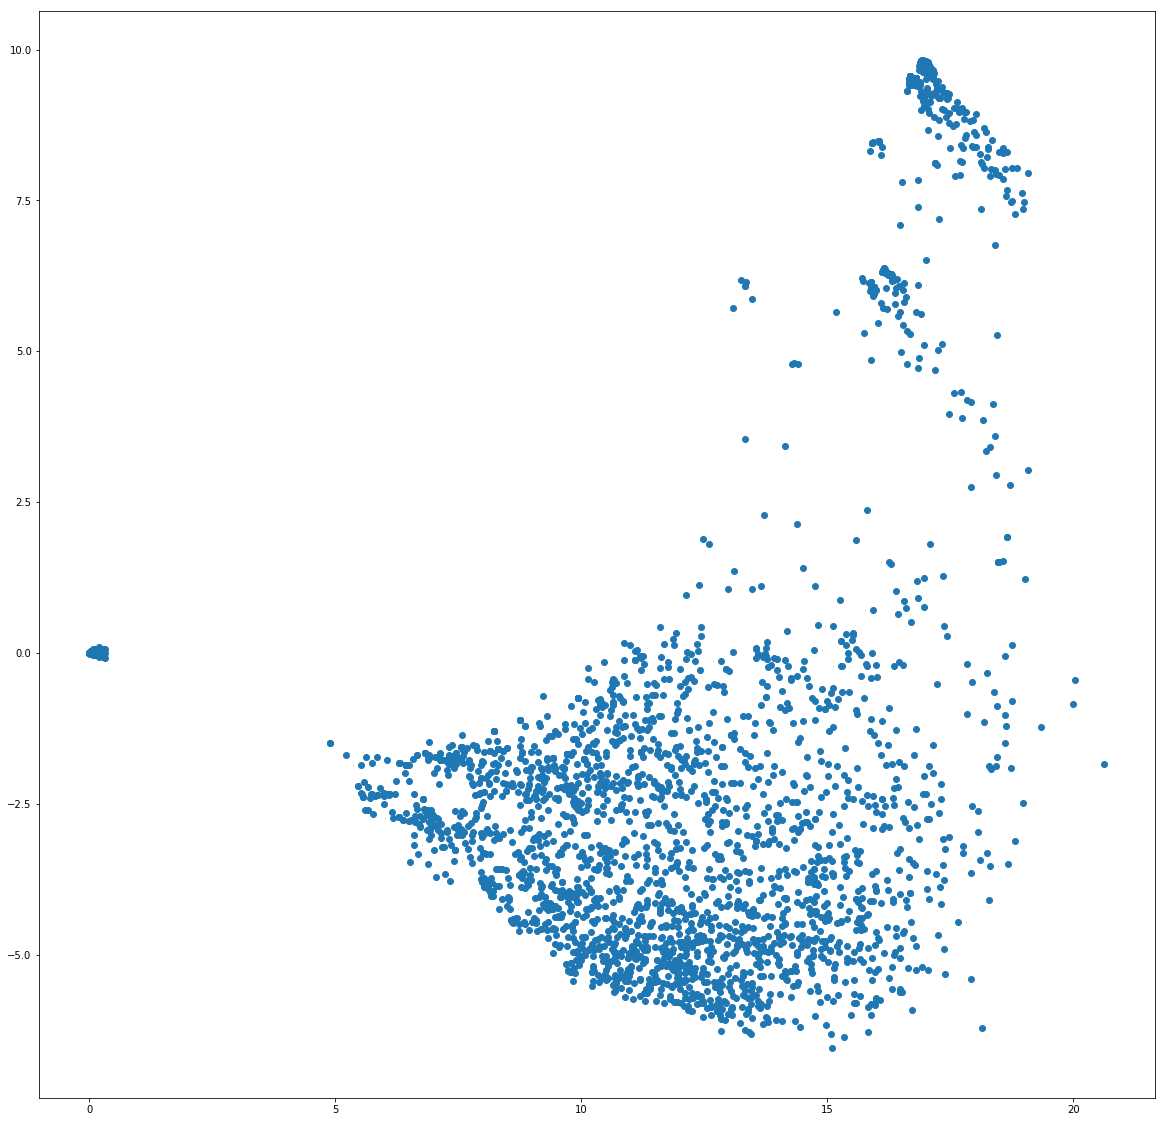

In [12]:
plt.figure(figsize=(20,20))
plt.scatter(*T.T)

## Next, we'll follow up a linear analysis by T-SNE for visualization purposes
Again, here I would expect to see clustering based on the package manager. It's sort of like what you would see with fMRI data if you don't account for the scanner / site. Here is a function to take a sparse matrix, M, and reduce it to a number of components `tsvd_components` using TSNE.

In [27]:
tsvd = TruncatedSVD(n_components=200)
T = tsvd.fit_transform(M)
tsne = TSNE(n_components=2)
NT = tsne.fit_transform(T)

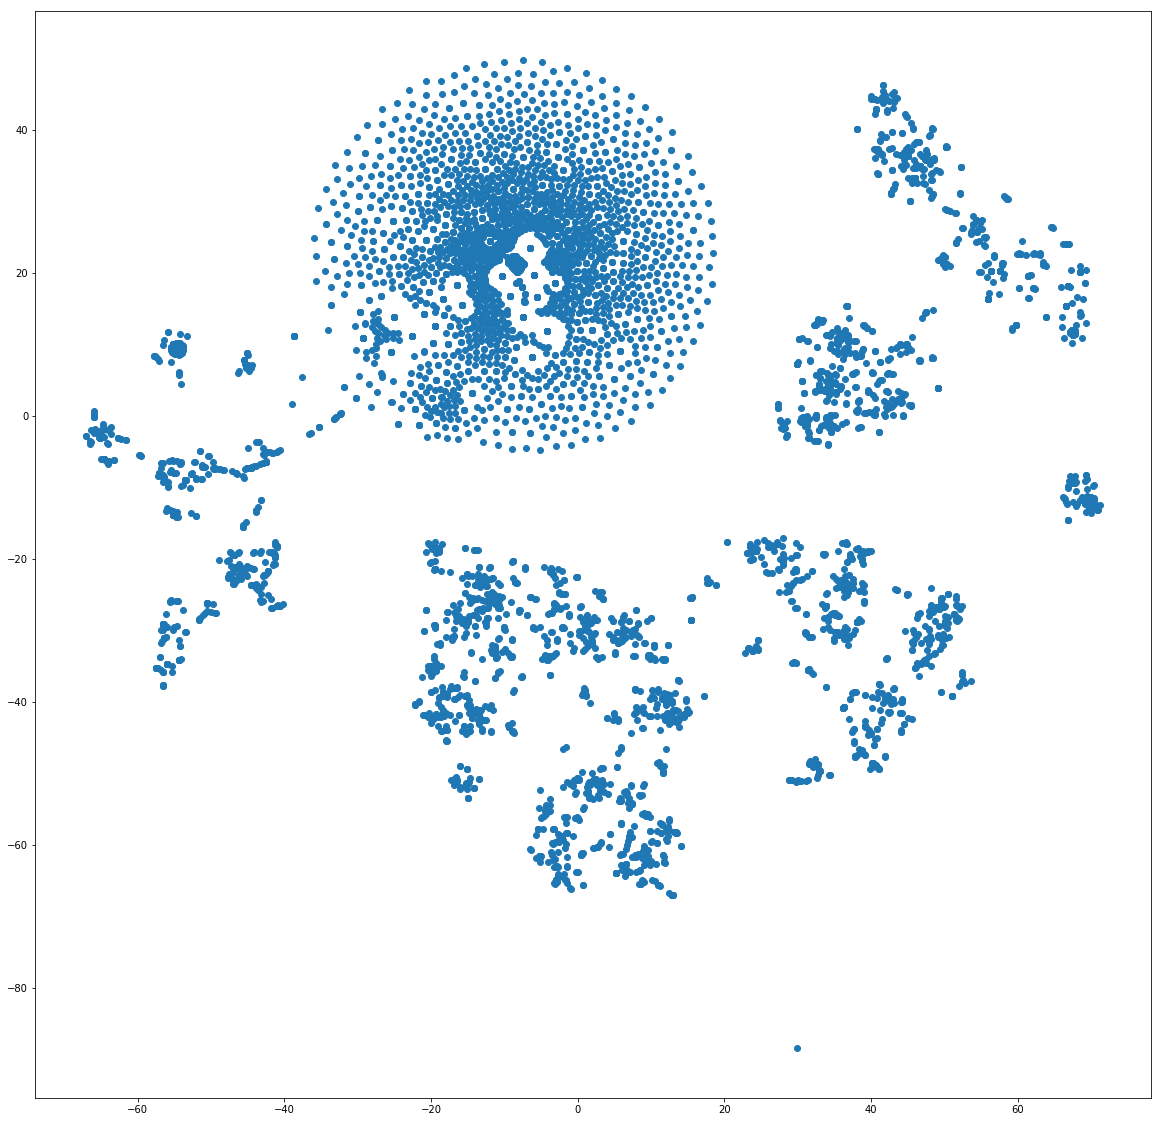

In [28]:
plt.figure(figsize=(20,20))
plt.scatter(*NT.T)

I am thinking that given we know the matrix is sparse, that big circle lump is datasets with all zeros. Let's see what happens when we remove empty rows.

In [45]:
results = results[(results.T != 0).any()]
M = sparse.lil_matrix(np.array(results.values, dtype=int))
M = sparse.csr_matrix(M)
tsvd = TruncatedSVD(n_components=200)
T = tsvd.fit_transform(M)
tsne = TSNE(n_components=2)
NT = tsne.fit_transform(T)

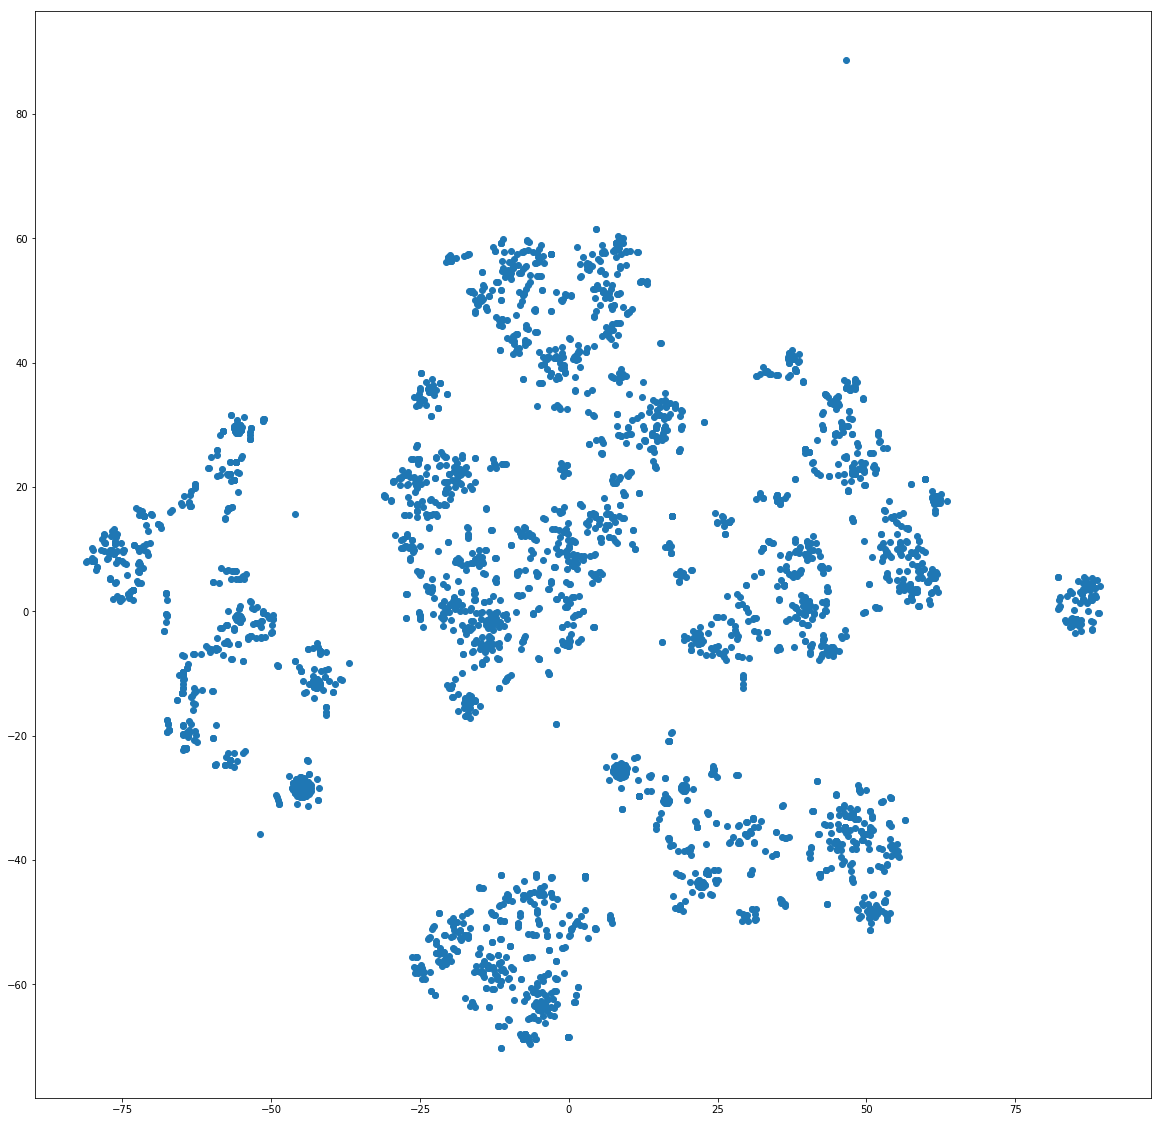

In [47]:
# What about now?
plt.figure(figsize=(20,20))
plt.scatter(*NT.T)

Much better! The above gives us a nice glance that there is structure in the data. But again, we are including sets of very different things (Apt and Pip) so we really need to first label the clusters to confirm this, and then separate the data. After separation, we will continue with some analysis on just the Pip subset (since the original intention of the analysis was to do this!)

## Labeling

Let's see if we can give meaning to the image by labeling some of the clusters. First, let's write a function that will plot the same data based on finding a substring in a package (we can then look for a substring like Apt__). We will also write a helper function to, given a list of columns, return the rows that have values == 1 (features is present).

In [29]:
def label_by_package_name(results, keywords, NT):
    '''plot the TSNE transform based on coloring containers that contain
       a software dependency that has one or more keywords (entirely or as
       subtring)
       
       Parameters
       ==========
       results: the pandas df, we get the index (container names) from here
       keywords: one or more keywords to look for in the df.columns
       NT: the transform from  (NT = tsne.fit_transform(T))
    '''
    packages = list(results.iloc[0].index)

    # Ensure we have a list of keywords
    if not isinstance(keywords, list):
        keywords = [keywords]
        
    # Which packages have the keywords?
    has_keywords = [i for (i, s) in enumerate(packages) if any(k in s for k in keywords)] 
    print('Found %s with keywords %s' %(len(has_keywords), ','.join(keywords)))

    # Make it sparse again!
    M = sparse.lil_matrix(np.array(results.values, dtype=int))
    M = sparse.csc_matrix(M)  ## csr matrix is fast to work with
    
    with_keywords = list(set(filter_rows_by_columns(M, has_keywords)))
    without_keywords = list(set(range(M.shape[0])) - set(with_keywords))
    
    points_with_keywords = NT[with_keywords, :]
    points_without_keywords = NT[without_keywords, :]
    
    plt.figure(figsize=(20,20))
    plt.title("With keywords %s" %','.join(keywords), fontsize=24)
    plot_with_keywords = plt.scatter(*points_with_keywords.T, c='b')
    plot_without_keywords = plt.scatter(*points_without_keywords.T, c='r')
    plt.legend( (plot_with_keywords, plot_without_keywords), ("with keyword " + "".join(keywords),
                                                              "without keyword "), fontsize=24)
    plt.show()
    return plt

def filter_rows_by_columns(M, columns):
    """Efficient method for filtering rows (aka container) by columns (aka package)"""
    rows = []
    for c in columns:  ## iterate through columns
        for ind in range(M.indptr[c], M.indptr[c+1]):
            if M.data[ind]:
                rows.append(M.indices[ind])
    return rows

## Label (Color) by Keywords
Now we can label by a keyword, such as a package manager ("Apt") or a random keyword string in the package name (manager).

Found 99 with keywords manager


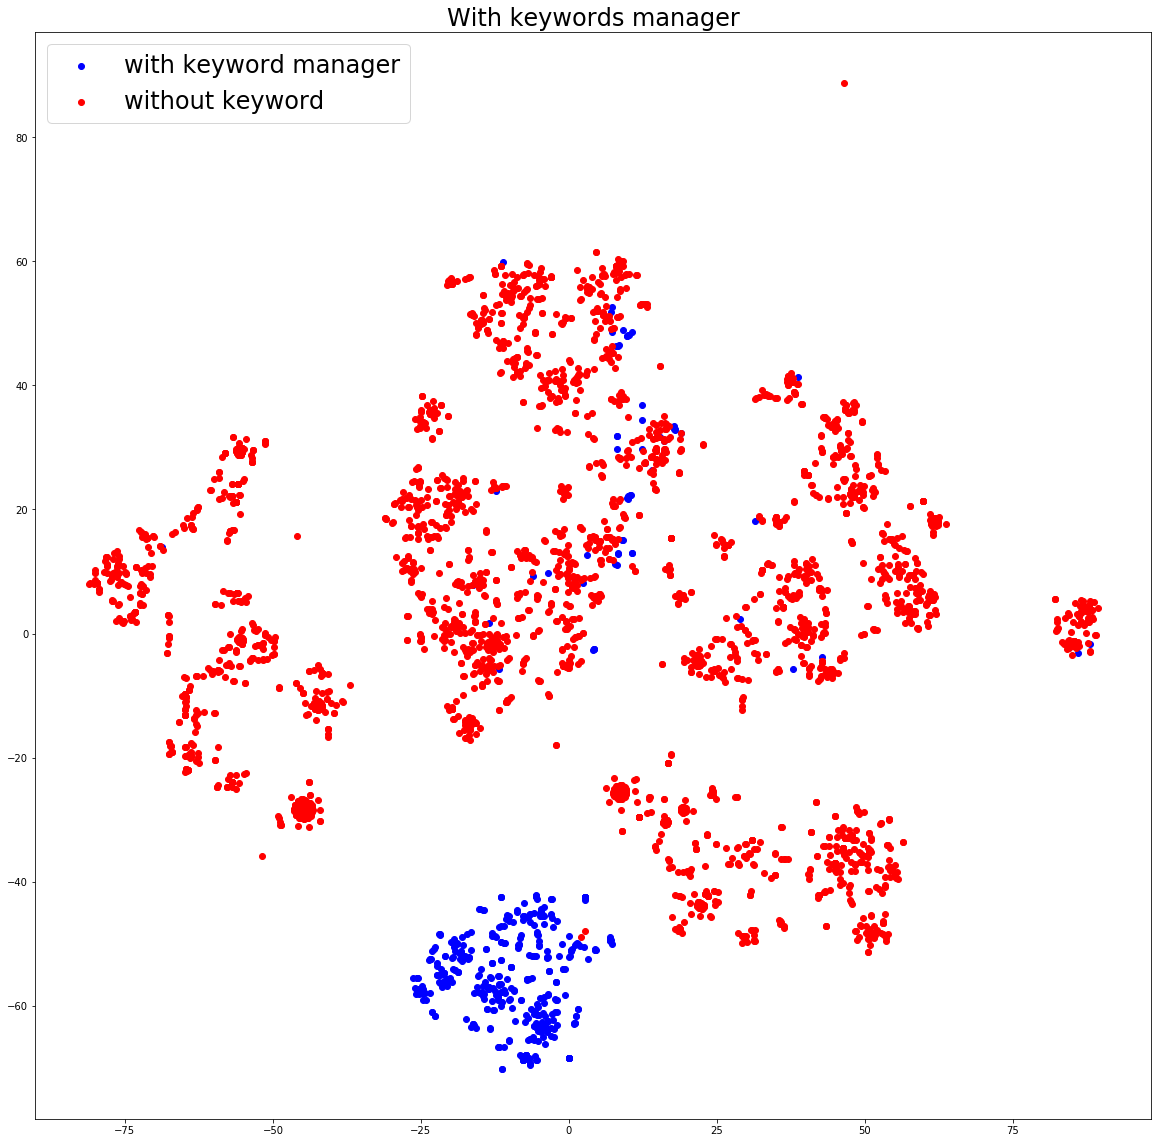

<module 'matplotlib.pylab' from '/home/vanessa/anaconda3/lib/python3.6/site-packages/matplotlib/pylab.py'>

In [48]:
label_by_package_name(results, ["manager"], NT)

That's pretty neat. If you do a [search on pypi](https://pypi.org/search/?q=manager) there are a ton of packages with "manager" in the name. What about "sci" ?

Found 62 with keywords sci


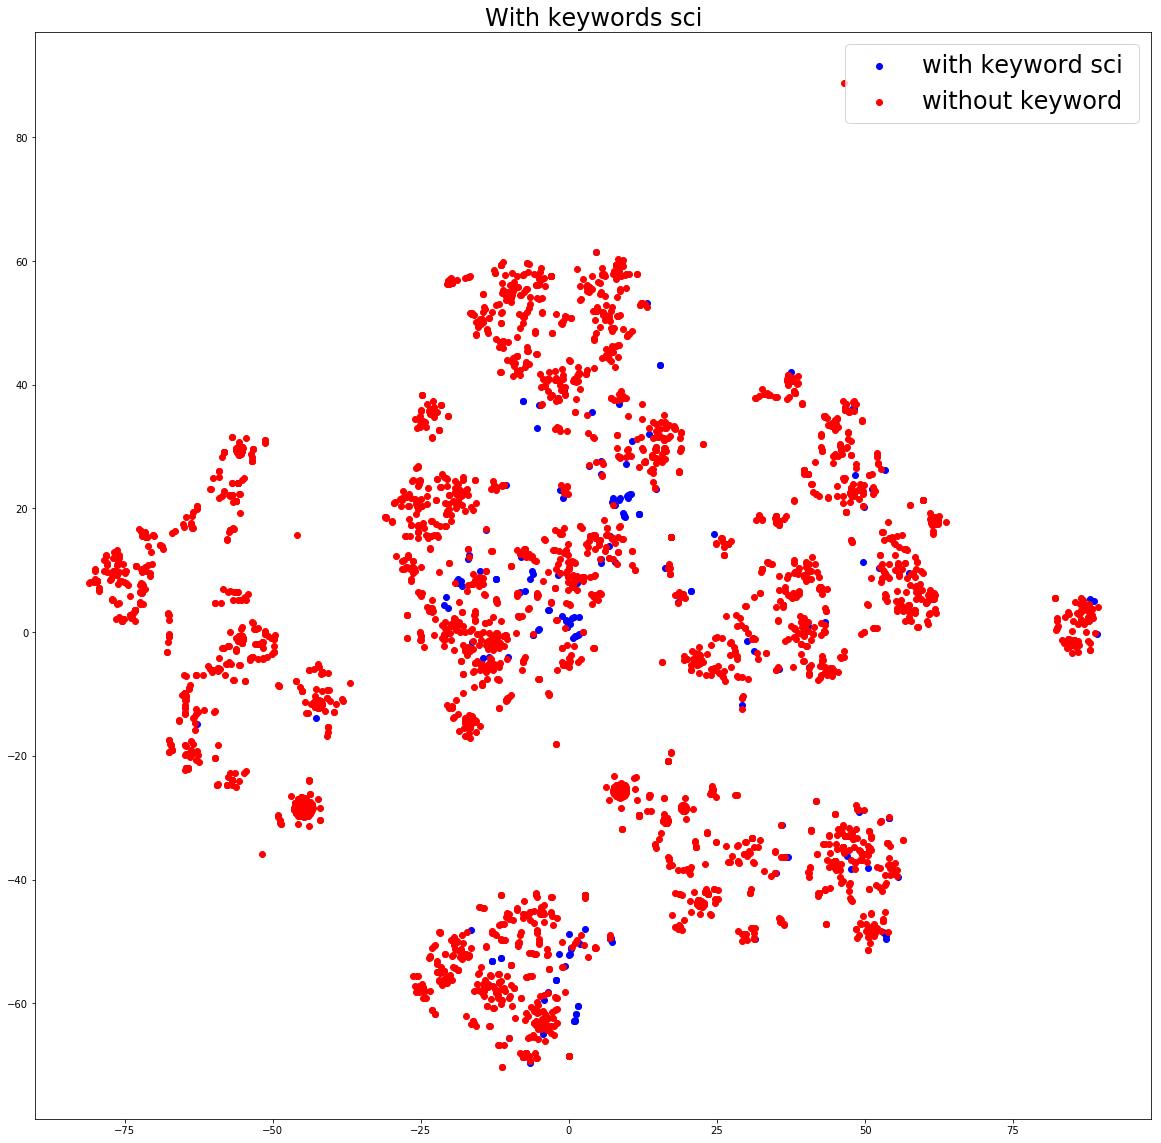

<module 'matplotlib.pylab' from '/home/vanessa/anaconda3/lib/python3.6/site-packages/matplotlib/pylab.py'>

In [49]:
label_by_package_name(results, ["sci"], NT)

And let's see if we are really any better than the R community, that names eveRything with the appRopRiate R.'

Found 3245 with keywords py


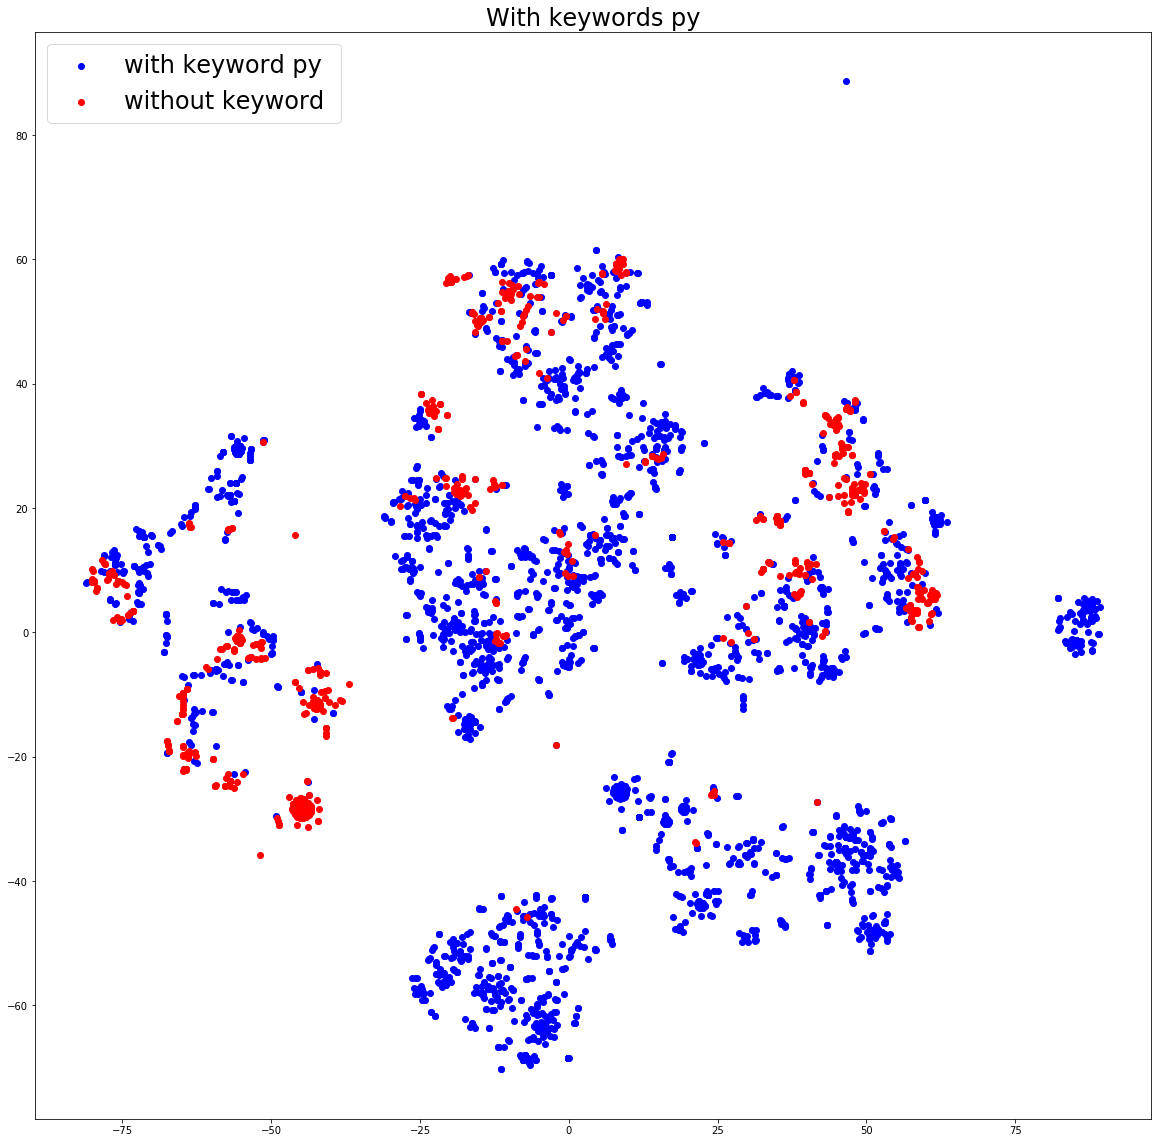

<module 'matplotlib.pylab' from '/home/vanessa/anaconda3/lib/python3.6/site-packages/matplotlib/pylab.py'>

In [52]:
label_by_package_name(results, ["py"], NT)

# Label By Container Base

There is definitely interesting signal in this data, and I'm only scraping the surface. This is only 6K of the 60K dataset that is extracting too. Let's see if we can find anything with respect to container names.

In [54]:
# Now let's use our labels and label by container names!

# Let's load some labels! These are rough, but will do the trick to show *some* signal
label_sets = pickle.load(open('df-labels-6k.pkl','rb'))
print(label_sets.keys())
# Above we see that we have labels: as they are originally e.g., <library>/<image>:<tag
#                                   without tags e.g.,           <library>/<image>
#                                   without library or tag name  <image>
#
# The last one is most general and good for our labeling here!  

# How many unique?
print(len(set(label_sets['images'])))

dict_keys(['notag', 'images', 'fromheaders'])
1079


In [55]:
def label_by_container_name(results, bases, labels, NT):
    '''plot the TSNE transform based on coloring containers from a list
       of strings to identify them (e.g., container FROM names)
       
       Parameters
       ==========
       results: the pandas df, we get the index (container names) from here
       bases: some subset of bases we are interested in (e.g., debian)
       labels: a list of labels
       NT: the transform from  (NT = tsne.fit_transform(T))
    '''

    has_bases = []
    without_bases = []
    for i in range(len(labels)):
        label = labels[i]
        if label in bases:
            has_bases.append(i)
        else:
            without_bases.append(i)

    print('Found %s with bases %s' %(len(has_bases), ','.join(bases)))

    # Make it sparse again!
    M = sparse.lil_matrix(np.array(results.values, dtype=int))
    M = sparse.csc_matrix(M)  ## csr matrix is fast to work with
        
    points_with_bases = NT[has_bases, :]
    points_without_bases = NT[without_bases, :]
    
    plt.figure(figsize=(20,20))
    plt.title("With bases %s" %','.join(bases), fontsize=24)
    plot_with_bases = plt.scatter(*points_with_bases.T, c='b')
    plot_without_bases = plt.scatter(*points_without_bases.T, c='r')
    plt.legend( (plot_with_bases, plot_without_bases), ("with bases " + ",".join(bases),
                                                        "without"), fontsize=24)
    plt.show()
    return plt

# Yes, redundant, it's okay

Remember how we filtered down to rows that weren't all zeros? This will be problematic if we try to use these labels. Thanksfully, we have the container names in a vector that corresponds with the original index of the data frame. We can find the indices of this vector that are still in the data frame.'

In [70]:
#original = pickle.load(open(input_file,'rb'))
# Get the indices of the non empty ones, doing it stupidly because I'm tired
keepers = []
idx = 0
for row in results.iterrows():
    if row[1].sum() > 0:
        keepers.append(idx)
    idx+=1

print(len(keepers))
print(results.shape)

3700
(3700, 32913)


Good! From the above we've hacked our way to getting the right indices. Now we can use them to 
filter our label subsets. A note for myself and readers - this kind of "hack" is really not acceptable, we needed to have extracted the original row names with the label sets, or at least included indices, so we wouldn't need to do this.

In [73]:
# Good! From the above we've hacked our way to getting the right indices. Now we can use them to 
# filter our label subsets

labels_images = [label_sets['images'][x] for x in range(len(label_sets['images'])) if x in keepers]
labels_from = [label_sets['fromheaders'][x] for x in range(len(label_sets['fromheaders'])) if x in keepers]
labels_notag = [label_sets['notag'][x] for x in range(len(label_sets['notag'])) if x in keepers]

In [80]:
# Let's look at counts for the image bases
counts = dict()
for label in labels_images:
    if label not in counts:
        counts[label] = 0
    counts[label] += 1
    
print(sorted(counts, key=counts.get, reverse=True)[0:15])
print(counts['ubuntu'])

['ubuntu', 'python', 'alpine', 'debian', 'node', 'centos', 'phusion', 'php', 'ruby', 'golang', 'nginx', 'mhart', 'java', 'openjdk', 'fedora']
723


Found 397 with bases python


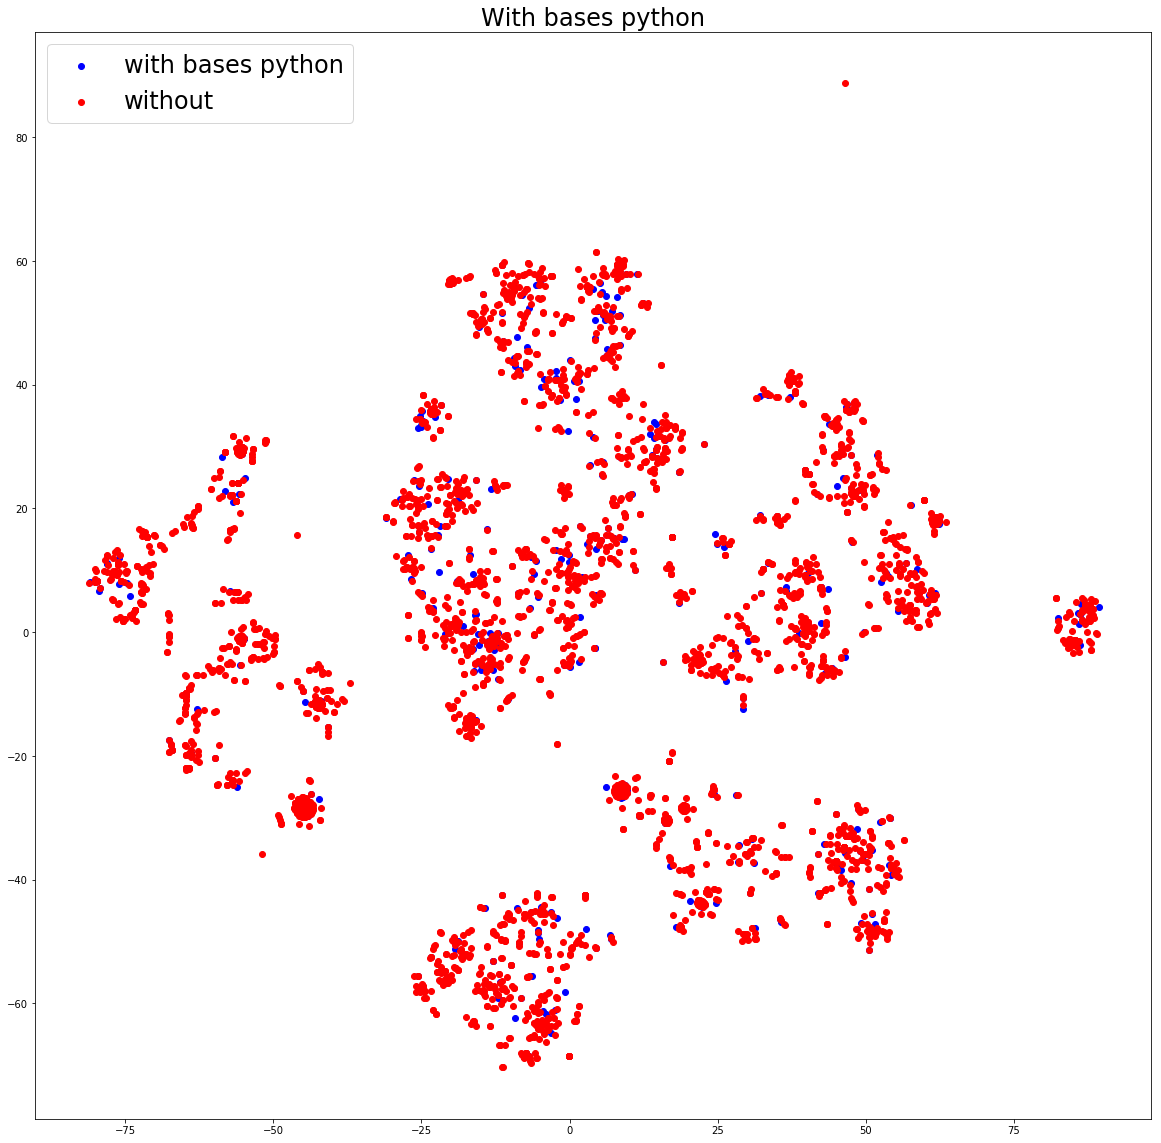

<module 'matplotlib.pylab' from '/home/vanessa/anaconda3/lib/python3.6/site-packages/matplotlib/pylab.py'>

In [74]:
# Now we can label based on the image base names - how many python?
label_by_container_name(results, ["python"], labels_images, NT)

Found 993 with bases ubuntu,debian


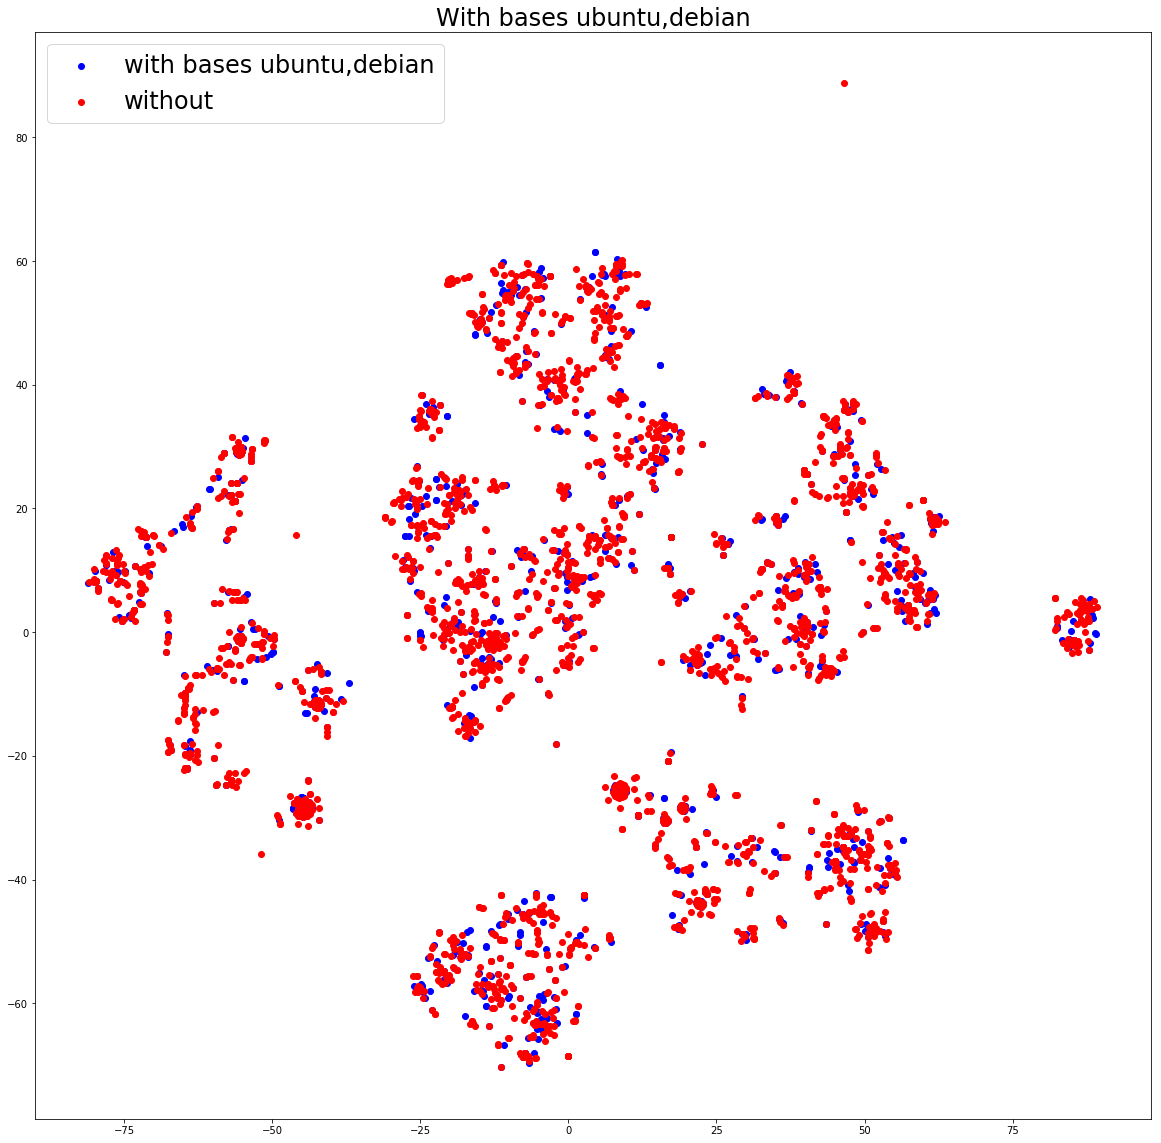

<module 'matplotlib.pylab' from '/home/vanessa/anaconda3/lib/python3.6/site-packages/matplotlib/pylab.py'>

In [81]:
# How many debian flavor?
label_by_container_name(results, ["ubuntu", "debian"], labels_images, NT)

And here we see a problem - we aren't actually looking at all of the (library) bases, for many there is some other container that 
the container is bootstrapping that might have many previous layers before we get to a library container, then scratch. 
These labels aren't super meaningful, but only tell us that we are missing a lot of information but just looking at one level of base image.'

# Summary
In summary, I want to show you that there is interesting structure. I don't know what it means. I want to encourage you to better understand the guts of your containers. You can use container-diff to extract the libraries, and I hope that you can do interesting machine learning to better understand how we can compare containers.